In [1]:
import logging
logging.basicConfig(filename='vae.log', level=logging.INFO)

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import os
import torch
import matplotlib.pyplot as plt
exportdir='/data/localhost/taufiq/export-dir/'
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
models_dir = '/data/localhost/taufiq/dryrun/'

In [3]:
col_name = 'HR'
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [4]:
pulse_data['icustay_id'] = pulse_data['id'].astype(int)
pulse_data = pulse_data.reset_index()
pulse_data.head()

,index,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),id,time,icustay_id
0,0,36942.076357,40.766614,89.927432,116.205401,1589.280619,7.406174,12.954165,6432.049911,48.181075,...,18.633540,4.638695,0.0,33.203250,3328.440581,119.230483,7000.0,86855.0,6.607069e+09,86855
1,1,36524.917484,40.872763,90.052348,92.470480,1589.598103,7.405145,13.608056,6492.148657,53.043316,...,18.750000,4.633428,3600.0,33.879672,3319.123490,122.674910,7000.0,86855.0,6.607073e+09,86855
2,2,36069.948819,40.889780,90.176441,105.766357,1589.422211,7.404981,14.168092,6560.608547,57.671101,...,18.750000,4.633453,7200.0,32.973720,3311.273411,123.910096,7000.0,86855.0,6.607076e+09,86855
3,3,35344.795982,40.949980,90.585038,99.518088,1589.162254,7.404399,14.827684,6681.667603,61.641868,...,18.867925,4.635279,10800.0,33.382638,3311.388720,121.909499,7000.0,86855.0,6.607080e+09,86855
4,4,34739.622499,40.941064,90.624763,120.664434,1589.148171,7.404485,14.816667,6784.488523,65.534987,...,18.867925,4.635250,14400.0,33.415902,3280.588569,122.044169,7000.0,86855.0,6.607084e+09,86855


In [5]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'BloodUreaNitrogenConcentration (mg/dL)': 'BUN',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SaturationAndFractionOfInspiredOxygenRatio (None)': 'PaO2_FiO2',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

pulse_data = pulse_data.rename(columns=pulse_rename)

In [6]:
MIMICtable = pd.read_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-train.csv")
MIMICtable['icustay_id'] = MIMICtable['icustay_id'].astype(int)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


## Create Actions


In [7]:
nra = 5
nr_reps = 2

In [8]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [9]:
len(MIMICtable)

25840

In [10]:
MIMICtable['A'] = actionbloc['action_bloc']

In [11]:
a_columns = ['A']
x_columns = ['gender', 'age', 'Weight_kg', 'paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']

In [12]:
MIMICtable_filtered_t0 = MIMICtable[MIMICtable['bloc']==1].reset_index()
MIMICtable_filtered_t1 = MIMICtable[MIMICtable['bloc']==2].reset_index()
MIMICtable_filtered_t2 = MIMICtable[MIMICtable['bloc']==3].reset_index()
MIMICtable_filtered_t3 = MIMICtable[MIMICtable['bloc']==4].reset_index()
MIMICtable_filtered_t4 = MIMICtable[MIMICtable['bloc']==5].reset_index()

MIMICtable_filtered_t1 = MIMICtable_filtered_t1[MIMICtable_filtered_t1[x_columns[1:]].min(axis=1)>0].reset_index()

MIMICtable_filtered_t2 = MIMICtable_filtered_t2[MIMICtable_filtered_t2[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t3 = MIMICtable_filtered_t3[MIMICtable_filtered_t3[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)
MIMICtable_filtered_t4 = MIMICtable_filtered_t4[MIMICtable_filtered_t4[x_columns[1:]].min(axis=1)>0].reset_index(drop=True)

In [13]:
MIMIC_t0 = MIMICtable_filtered_t0[['icustay_id'] + x_columns + a_columns].copy()
MIMIC_t1 = MIMICtable_filtered_t1[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t2 = MIMICtable_filtered_t2[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t3 = MIMICtable_filtered_t3[['icustay_id'] + x_columns[3:] + a_columns].copy()
MIMIC_t4 = MIMICtable_filtered_t4[['icustay_id'] + x_columns[3:] + a_columns].copy()

mimic_t0_rename = {}
mimic_t1_rename = {}
mimic_t2_rename = {}
mimic_t3_rename = {}
mimic_t4_rename = {}

for col in (x_columns[3:] + a_columns):
    mimic_t0_rename.update({col: f"{col}_t0"})
    mimic_t1_rename.update({col: f"{col}_t1"})
    mimic_t2_rename.update({col: f"{col}_t2"})
    mimic_t3_rename.update({col: f"{col}_t3"})
    mimic_t4_rename.update({col: f"{col}_t4"})
    MIMIC_t0 = MIMIC_t0.rename(columns=mimic_t0_rename)
    MIMIC_t1 = MIMIC_t1.rename(columns=mimic_t1_rename)
    MIMIC_t2 = MIMIC_t2.rename(columns=mimic_t2_rename)
    MIMIC_t3 = MIMIC_t3.rename(columns=mimic_t3_rename)
    MIMIC_t4 = MIMIC_t4.rename(columns=mimic_t4_rename)

MIMIC_combined = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t2, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t3, on=['icustay_id'])
MIMIC_combined = MIMIC_combined.merge(MIMIC_t4, on=['icustay_id'])

In [14]:
MIMIC_combined_raw = MIMIC_combined.copy()

for col in x_columns[3:]:
    MIMIC_combined_raw[f'{col}_t0'] = (MIMIC_combined[f'{col}_t0'] - MIMIC_combined[f'{col}_t0'].mean())/MIMIC_combined[f'{col}_t0'].std()
    MIMIC_combined_raw[f'{col}_t1'] = (MIMIC_combined[f'{col}_t1'] - MIMIC_combined[f'{col}_t1'].mean())/MIMIC_combined[f'{col}_t1'].std()
    MIMIC_combined_raw[f'{col}_t2'] = (MIMIC_combined[f'{col}_t2'] - MIMIC_combined[f'{col}_t2'].mean())/MIMIC_combined[f'{col}_t2'].std()
    MIMIC_combined_raw[f'{col}_t3'] = (MIMIC_combined[f'{col}_t3'] - MIMIC_combined[f'{col}_t3'].mean())/MIMIC_combined[f'{col}_t3'].std()
    MIMIC_combined_raw[f'{col}_t4'] = (MIMIC_combined[f'{col}_t4'] - MIMIC_combined[f'{col}_t4'].mean())/MIMIC_combined[f'{col}_t4'].std()


MIMIC_combined_raw['age'] = (MIMIC_combined['age']-MIMIC_combined['age'].mean())/MIMIC_combined['age'].std()
MIMIC_combined_raw['Weight_kg'] = (MIMIC_combined['Weight_kg']-MIMIC_combined['Weight_kg'].mean())/MIMIC_combined['Weight_kg'].std()

In [15]:
len(MIMIC_combined.columns)

84

In [391]:
gender = 0.0

In [392]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

latent_dim = 50
hidden_dim = 200
data_dim = 77
n_act = 25

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc11 = nn.Linear(data_dim, hidden_dim)
        self.fc12 = nn.Linear(hidden_dim, hidden_dim)
        self.fc13 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc41 = nn.Linear(hidden_dim, hidden_dim)
        self.fc42 = nn.Linear(hidden_dim, hidden_dim)
        self.fc43 = nn.Linear(hidden_dim, data_dim)
        self.fc44 = nn.Linear(hidden_dim, data_dim)
        self.fc45 = nn.Linear(hidden_dim, int(data_dim*(data_dim-1)/2))
        self.fc46 = nn.Linear(latent_dim, n_act)

    def encode(self, x):
        h1 = torch.tanh(self.fc11(x))
        h1 = F.leaky_relu(self.fc12(h1))
        h1 = F.leaky_relu(self.fc13(h1))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.leaky_relu(self.fc3(z))
        h3 = torch.tanh(self.fc41(h3))
        h3 = F.leaky_relu(self.fc42(h3))
        t = torch.tril_indices(row=data_dim-1, col=data_dim-1, offset=0)
        lower_tr = torch.zeros((z.shape[0], data_dim, data_dim))
        lower_tr[:, t[0]+1, t[1]] = self.fc45(h3)
        cov_mat = torch.multiply(lower_tr, lower_tr.transpose(1,2))
        diag_var = self.fc44(h3).exp()
        cov_mat[:, torch.arange(data_dim), torch.arange(data_dim)] = diag_var
        return self.fc43(h3), cov_mat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        dec_mu, dec_cov_mat = self.decode(z)
        return dec_mu, dec_cov_mat, mu, logvar

In [518]:
icuuniqueids = MIMIC_combined['icustay_id'].unique()

grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
                                    
train = torch.utils.data.TensorDataset(X)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = torch.utils.data.TensorDataset(Xtestmimic)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

In [519]:
def loss_function_deprecated(recon_x, logvar_lik, x, mu, logvar):
#     BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
#     mse_loss = F.mse_loss(torch.div(recon_x, ), x, reduction='sum')
    mse_loss = torch.sum(torch.square(recon_x - x)/2/torch.exp(logvar_lik) + 0.5*logvar_lik)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + KLD

In [520]:
def loss_function(dec_mu, dec_covmat, x, mu, logvar):
    nlog_lik = (0.5*((dec_mu - x).unsqueeze(dim=1) @ dec_covmat.inverse() @ (dec_mu - x).unsqueeze(dim=2)).squeeze() + 0.5*dec_covmat.logdet()).sum()

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return nlog_lik + KLD

In [521]:
device = 'cpu'
model = VAE().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0, betas=(0.99,0.999), amsgrad=True)
# optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.1, centered=True, momentum=0.9) -- seems fairly good
optimizer = optim.RMSprop(model.parameters(), lr=1e-5, weight_decay=0.0, centered=True, momentum=0.9)
test_losses = []
train_loss = 0

In [522]:
epochs = 300
for epoch in tqdm(range(epochs), position=0, leave=True):
    for data, in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        dec_mu, dec_cov_mat, mu, logvar = model(data)
        loss = loss_function(dec_mu, dec_cov_mat, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        test_loss = 0
        with torch.no_grad():
            for testdata, in testloader:
                testdata = testdata.to(device)
                recon_batch, logvar_lik, mu, logvar = model(testdata)
                test_loss += loss_function(recon_batch, logvar_lik, testdata, mu, logvar).item()
            test_losses.append(test_loss/len(testloader.dataset))

100%|██████████| 300/300 [06:31<00:00,  1.30s/it]


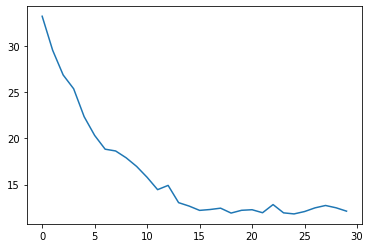

In [523]:
plt.plot(test_losses)

In [524]:
from torch.distributions.multivariate_normal import MultivariateNormal

def sample_multivariate(mu, cov):
    m = MultivariateNormal(mu, covariance_matrix=cov)
    return m.sample()

In [525]:
with torch.no_grad():
    sample = torch.randn(20000, latent_dim).to(device)
    mu, cov = model.decode(sample)
    sample = sample_multivariate(mu, cov)
print(sample)

tensor([[-0.0085, -1.0957, -0.2467,  ..., -0.5686, -0.4964, -0.5146],
        [-0.1685, -0.5541,  0.4605,  ...,  0.0095,  0.6217,  0.5085],
        [ 0.0278, -2.7206, -0.4465,  ...,  0.3202, -0.1019, -0.7907],
        ...,
        [ 2.0007, -0.3703,  1.3921,  ..., -0.7064,  1.4396,  0.1898],
        [-1.6831,  1.7136, -1.6033,  ...,  0.5333,  1.3134,  0.9556],
        [-1.3144, -1.3724, -1.2369,  ...,  0.5481,  0.1003,  0.5446]])


In [526]:
sample.shape
MIMIC_filtered = MIMIC_combined.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4'])
resampled = pd.DataFrame(data=sample.numpy(), columns=MIMIC_filtered.columns)*MIMIC_filtered.std() + MIMIC_filtered.mean()
resampled

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t4,DiaBP_t4,Glucose_t4,MeanBP_t4,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4
0,23832.193245,55.210393,40.089567,194.416230,1709.216439,7.445745,77.044905,3406.926785,59.574287,2842.634864,...,3287.169360,68.154366,2574.566972,75.956939,154.152533,20.607331,36.583942,3097.997106,109.671245,76.907547
1,22873.621026,68.531044,48.822940,91.285906,1323.476895,7.499004,91.686139,3301.135201,59.342156,1065.330446,...,3685.607158,62.050205,858.211128,78.621171,170.277438,20.944791,37.317977,3171.210569,133.219191,95.061127
2,24049.314899,15.246774,37.622156,244.326904,1517.344023,7.316952,84.697336,3712.552399,58.902043,1427.211700,...,3745.126973,59.700863,1547.689969,82.352501,158.139176,15.511110,36.824115,3210.560151,117.980263,72.009069
3,24087.029713,90.833317,58.199225,89.952651,1968.729838,7.367603,84.460801,3632.521086,56.746091,1659.120450,...,3664.609718,66.435712,1784.553526,89.247443,154.998290,22.314930,37.548684,3220.919711,137.477721,88.661675
4,19995.925588,90.400111,49.247557,173.498291,1004.404524,7.091200,79.861743,3726.604893,57.860118,3018.898380,...,3741.576407,91.094754,3016.539631,91.375895,214.304811,24.229284,36.848720,3234.004985,125.594835,116.277215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,30349.183378,60.954815,58.846496,74.602808,1398.413720,7.329409,91.669264,3617.439549,75.002704,1761.206223,...,3291.097803,69.009978,2136.158077,100.684741,173.978141,17.395899,36.204911,3221.904083,160.738470,72.790589
19996,25847.307450,94.649581,48.742125,376.368588,1747.346668,7.329472,88.337889,3895.019558,69.202902,2481.439989,...,3452.465842,73.482112,1563.064194,95.354068,192.711648,20.517622,37.744636,3193.612858,141.643428,73.375787
19997,35864.114747,73.050569,60.328256,202.273890,1954.247325,7.193170,82.527542,3474.362063,29.353111,926.126134,...,3595.258103,45.718979,1096.461426,92.097054,161.811815,22.547739,36.505659,3080.543200,150.446159,89.405396
19998,13803.599722,124.303939,23.335033,84.905931,1412.785105,7.459444,78.076806,4270.315816,60.015941,1499.370443,...,3630.782762,80.414366,835.243046,96.620019,133.186786,19.665020,37.938736,3237.538484,147.786358,102.992449


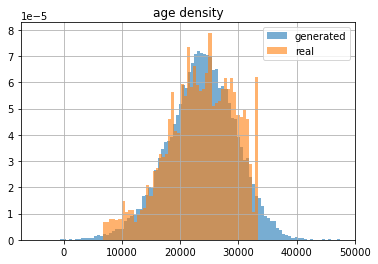

In [527]:
col_name = 'age'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

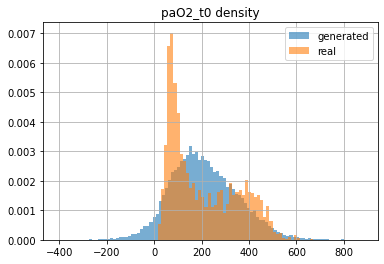

In [528]:
col_name = 'paO2_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

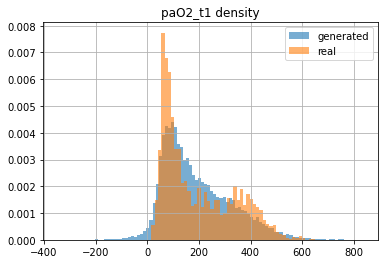

In [529]:
col_name = 'paO2_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

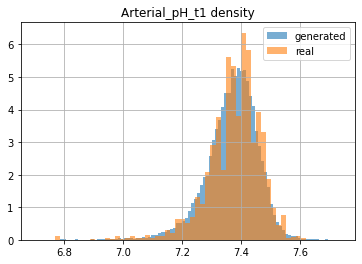

In [530]:
col_name = 'Arterial_pH_t1'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

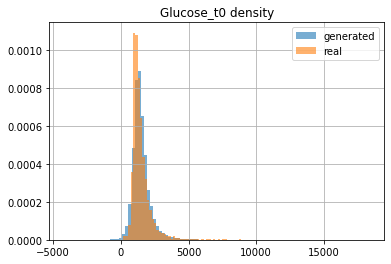

In [531]:
col_name = 'Glucose_t0'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

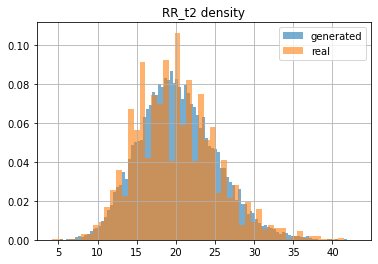

In [532]:
col_name = 'RR_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

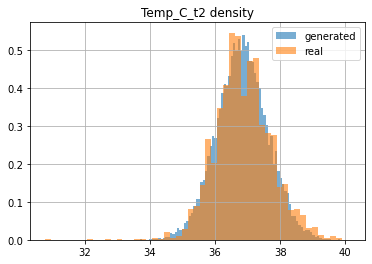

In [533]:
col_name = 'Temp_C_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

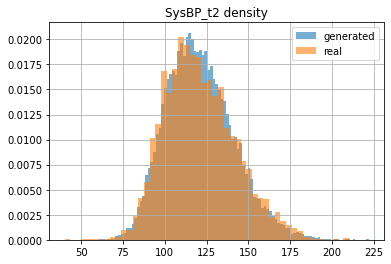

In [534]:
col_name = 'SysBP_t2'
resampled[col_name].hist(bins=100, density=True, alpha=0.6)
MIMIC_combined.loc[MIMIC_combined['gender']==gender, col_name].hist(bins=50, density=True, alpha=0.6)
plt.title(f'{col_name} density')
plt.legend(['generated', 'real'])

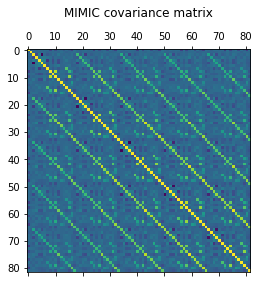

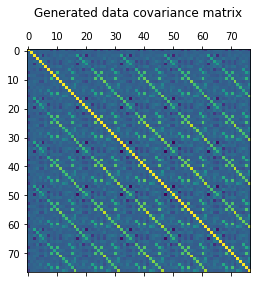

In [535]:
import matplotlib.pyplot as plt

plt.matshow(MIMIC_combined_raw[MIMIC_combined['gender']==gender].drop(columns=['icustay_id', 'gender']).corr())
plt.title('MIMIC covariance matrix\n')
plt.matshow(resampled.corr())
plt.title('Generated data covariance matrix\n')
plt.show()

# Predicting actions $a_0$ using $x_0$

In [536]:
Y = MIMIC_t0['A_t0']-1
MIMIC_t0_raw = MIMIC_t0.copy().drop(columns=['icustay_id', 'gender', 'A_t0'])
MIMIC_t0_raw = (MIMIC_t0_raw - MIMIC_t0_raw.mean())/MIMIC_t0_raw.std()

MIMIC_t0_raw

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,MeanBP_t0,Potassium_t0,RR_t0,Temp_C_t0,Sodium_t0,SysBP_t0,HR_t0
0,-0.181117,1.007453,-0.253429,-0.529249,-1.187524,-0.295180,0.663563,-2.268496,-0.050145,-0.384876,0.064755,1.091399,-1.135980,-0.740010,-0.336120,-0.493698,-0.571332
1,-1.043088,-0.645693,0.231879,0.244990,1.278422,-0.825567,-0.518063,-0.680805,0.419743,-0.585425,0.230326,-6.573458,0.690301,0.431068,-1.868385,-0.114322,-0.407150
2,0.019530,-0.336997,0.070110,1.473830,0.709358,0.129130,-1.995095,0.113041,-0.687850,-0.277916,-0.630646,0.133292,0.964243,0.188777,0.046946,-0.426750,0.003305
3,0.009449,-1.543348,-1.790237,-0.806271,-0.997836,2.144602,0.072750,-0.283882,1.594463,1.814479,1.356212,1.410768,1.603441,-0.376571,-0.910719,-0.002740,1.316759
4,1.180034,-0.361368,0.717187,0.181062,-0.049395,-1.355954,-0.813469,1.383193,0.352616,-0.451725,0.072115,0.133292,-1.744741,0.108011,1.196144,-0.344923,-0.699029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5163,-1.616092,-0.702558,-1.143160,-0.848890,-0.808148,1.189905,-0.222656,1.383193,0.128860,-0.545315,-0.450356,-1.303869,0.081540,-0.134280,1.196144,-1.103677,0.742123
5164,-1.644336,0.073243,-0.091660,-0.877302,0.709358,0.659518,-0.518063,0.113041,-1.135362,-0.572055,-0.796217,-0.072017,1.055557,-0.174662,-0.144587,0.146035,-1.282786
5165,-0.039246,0.723128,0.070110,1.935533,-0.997836,0.235208,-0.616532,1.065655,-0.385779,-0.852824,-0.111857,-0.744973,-1.501237,-0.416954,0.621545,0.265055,-2.158422
5166,1.587145,-0.869091,0.150994,-0.877302,-0.808148,0.129130,0.072750,-0.998343,0.386180,-0.358136,0.164098,0.133292,-0.405468,0.915651,-1.676852,-0.203587,0.267820


In [537]:
from sklearn.linear_model import LogisticRegression
icuuniqueids = MIMIC_t0.loc[MIMIC_t0['gender']==gender, 'icustay_id'].unique()
modelsDf = pd.DataFrame()

logging.info('Fitting models')

logging.info('Model: ' + str(model_n))
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = MIMIC_t0_raw.loc[(MIMIC_t0['gender']==gender) & MIMIC_t0['icustay_id'].isin(trainidx)]
Xtestmimic = MIMIC_t0_raw[(MIMIC_t0['gender']==gender) & (MIMIC_t0['icustay_id'].isin(testidx))]
Y = MIMIC_t0.loc[(MIMIC_t0['gender']==gender) & MIMIC_t0['icustay_id'].isin(trainidx), 'A_t0']-1
Ytest = MIMIC_t0.loc[(MIMIC_t0['gender']==gender) & (MIMIC_t0['icustay_id'].isin(testidx)), 'A_t0']-1

clf = LogisticRegression(random_state=0, max_iter=100000).fit(X, Y)
acc_train = clf.score(X, Y)
acc_test = clf.score(Xtestmimic, Ytest)
modelsDf = modelsDf.append({'model': model_n, 'regressor': clf, 'acc_train': acc_train, 'acc_test': acc_test}, ignore_index=True)
logging.info('Model fitting done!')

In [538]:
modelsDf

,acc_test,acc_train,model,regressor
0,0.549645,0.521489,1.0,"LogisticRegression(C=1.0, class_weight=None, d..."


In [539]:
from torch.distributions.categorical import Categorical

x_columns_t0 = x_columns[1:3]
for col in x_columns[3:]:
    x_columns_t0.append(f'{col}_t0')

sampled_t0 = pd.DataFrame(data=sample.numpy(), columns=MIMIC_filtered.columns)[x_columns_t0]
sampled_t0.head()
probs = torch.tensor(clf.predict_proba(sampled_t0))
m = Categorical(probs)
resampled['A_t0'] = (m.sample()+1).numpy()

# Using NN to model $\pi(a_0\mid x_0)$

In [540]:
import torch.utils.data as data_utils

class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_1_dim=10):
        super(PolicyNetwork, self).__init__()
        self.hid1 = torch.nn.Linear(input_dim, hidden_1_dim)
        self.outp = torch.nn.Linear(hidden_1_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=2)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.tanh = torch.nn.Tanh()

        torch.nn.init.xavier_uniform_(self.hid1.weight)
        torch.nn.init.zeros_(self.hid1.bias)
        torch.nn.init.xavier_uniform_(self.outp.weight)
        torch.nn.init.zeros_(self.outp.bias)

    def forward(self, x):
        z = self.tanh(self.hid1(x))
        z = self.outp(z)
        return z

In [541]:
X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx)), 'A_t0'].values-1).to(torch.long)

train = data_utils.TensorDataset(X, Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(Xtestmimic, Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1], output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [542]:
MIMIC_combined_raw.head()

,icustay_id,gender,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,...,DiaBP_t4,Glucose_t4,MeanBP_t4,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4,A_t4
0,65537,0.0,-0.180940,1.010000,-0.253953,-0.529489,-1.189026,-0.297304,0.675600,-2.265793,...,-0.143642,-0.426753,-0.194517,1.814688,0.859474,0.254585,-0.342662,-0.670767,-0.044426,2
1,65544,0.0,0.019618,-0.335812,0.069933,1.471917,0.707652,0.127247,-2.074139,0.112818,...,2.214545,-0.059964,2.175286,-0.009208,0.769281,-1.159040,0.201944,1.465944,1.237810,3
2,98314,0.0,0.009542,-1.543384,-1.792415,-0.806279,-0.999358,2.143862,0.064547,-0.283618,...,0.862055,3.298189,0.494039,3.638585,1.220246,4.117391,-0.705733,-0.670767,0.345412,6
3,14,0.0,1.179607,-0.360207,0.717707,0.180230,-0.051019,-1.358680,-0.852033,1.381410,...,0.388106,-0.679429,-0.395346,0.156601,-1.816251,0.221709,1.109622,0.231400,-0.941522,7
4,65553,0.0,-0.758628,-0.494382,0.150905,-1.154041,2.983665,1.719311,-0.139137,-2.265793,...,-0.962072,0.787725,-1.345551,0.322410,-0.673807,-0.370043,-0.524197,-1.468472,0.042935,2


In [543]:
for epoch in tqdm(range(500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:13<00:00, 36.94it/s]


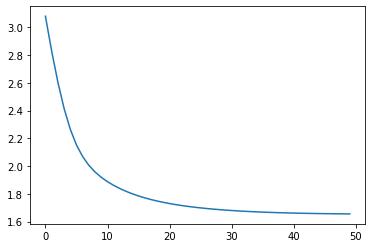

In [544]:
plt.plot(losses)

In [545]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(Xtestmimic)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 53 %


In [546]:
from torch.distributions.categorical import Categorical

probs = policy(sample)
m = Categorical(logits=probs)
resampled['A_t0'] = (m.sample()+1).numpy()

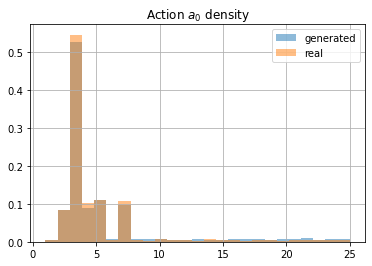

In [547]:
resampled['A_t0'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t0['A_t0'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_0$ density')
plt.show()

# Predicting actions $a_1$ using $x_0,a_0,x_1$

In [548]:
MIMIC_t1.head()

,icustay_id,paCO2_t1,paO2_t1,HCO3_t1,Arterial_pH_t1,Calcium_t1,Chloride_t1,DiaBP_t1,Glucose_t1,MeanBP_t1,Potassium_t1,RR_t1,Temp_C_t1,Sodium_t1,SysBP_t1,HR_t1,A_t1
0,65537,33.0,155.0,1769.4872,7.31,84.0,3651.35,63.0,1560.0,79.000000,173.335797,18.833333,35.833333,3126.608584,117.0,70.500000,2
1,65544,39.0,351.0,1342.3696,7.42,84.0,3686.80,41.5,1565.0,64.000000,232.634885,15.000000,37.444445,3172.588122,109.0,80.000000,3
2,98314,36.0,385.0,1159.3192,7.40,86.0,3651.35,88.0,2840.0,105.500000,187.671840,29.000000,36.444446,2988.669970,128.0,111.500000,3
3,14,31.0,179.0,1464.4032,7.45,77.0,3970.40,57.5,1125.0,76.666701,164.212860,10.000000,37.000000,3310.526736,115.0,65.666667,2
4,65553,85.0,36.0,1586.4368,7.33,102.0,3509.55,61.0,1100.0,76.500000,179.852180,21.000000,36.777776,3057.639277,107.5,79.000000,2


In [549]:
MIMIC_t0_t1 = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
a0 = MIMIC_t0_t1.loc[MIMIC_t0_t1['gender']==gender, 'A_t0']-1
a1 = MIMIC_t0_t1.loc[MIMIC_t0_t1['gender']==gender, 'A_t1']-1

MIMIC_t0_t1_raw = MIMIC_t0_t1.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1'])
MIMIC_t0_t1_raw = (MIMIC_t0_t1_raw - MIMIC_t0_t1_raw.mean())/MIMIC_t0_t1_raw.std()
MIMIC_t0_t1_raw.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t1,DiaBP_t1,Glucose_t1,MeanBP_t1,Potassium_t1,RR_t1,Temp_C_t1,Sodium_t1,SysBP_t1,HR_t1
0,-0.181567,1.007970,-0.253700,-0.530017,-1.187392,-0.295179,0.674781,-2.269199,-0.052227,-0.384849,...,-0.039981,0.331375,0.126324,-0.028581,0.419257,-0.246871,-1.184302,-0.332579,-0.240681,-0.919263
1,0.018956,-0.337819,0.070225,1.471760,0.709754,0.128852,-2.058093,0.112666,-0.691035,-0.278002,...,0.114685,-1.144433,0.133507,-1.023484,2.739072,-0.941368,0.677170,0.040593,-0.605022,-0.403627
2,0.008881,-1.545369,-1.792345,-0.806859,-0.997677,2.142997,0.067476,-0.284311,1.595227,1.812194,...,-0.039981,2.047430,1.965028,1.729080,0.980092,1.595057,-0.478226,-1.452096,0.260289,1.306112
3,1.178743,-0.362213,0.718075,0.179833,-0.049104,-1.355255,-0.843482,1.382994,0.351231,-0.451629,...,1.352013,-0.046157,-0.498547,-0.183341,0.062363,-1.847234,0.163660,1.160110,-0.331766,-1.181604
4,-0.759155,-0.496386,0.151206,-1.154685,2.986330,1.718966,-0.134959,-2.269199,-0.085848,-0.464984,...,-0.658644,0.194091,-0.534460,-0.194398,0.674182,0.145671,-0.093097,-0.892337,-0.673336,-0.457905


In [550]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 1, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [557]:
for epoch in tqdm(range(500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:13<00:00, 37.78it/s]


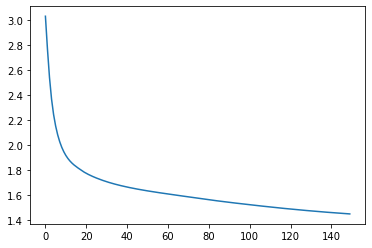

In [558]:
plt.plot(losses)

In [559]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 54 %


In [560]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
probs = policy(torch.column_stack((sample, a0)))
m = Categorical(logits=probs)
resampled['A_t1'] = (m.sample()+1).numpy()

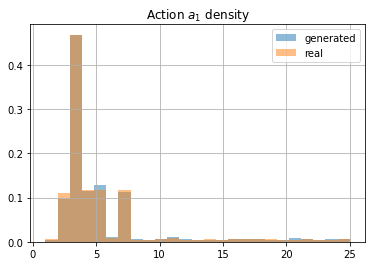

In [561]:
resampled['A_t1'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t1['A_t1'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_1$ density')
plt.show()

# Predicting actions $a_2$ using $x_0,a_0,x_1, a_1, x_2$

In [562]:
MIMIC_t0_t1_t2 = MIMIC_t0.merge(MIMIC_t1, on=['icustay_id'])
MIMIC_t0_t1_t2 = MIMIC_t0_t1_t2.merge(MIMIC_t2, on=['icustay_id'])

a0 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t0']-1
a1 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t1']-1
a2 = MIMIC_t0_t1_t2.loc[MIMIC_t0_t1_t2['gender']==gender, 'A_t2']-1

MIMIC_t0_t1_t2_raw = MIMIC_t0_t1_t2.drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2'])
MIMIC_t0_t1_t2_raw = (MIMIC_t0_t1_t2_raw - MIMIC_t0_t1_t2_raw.mean())/MIMIC_t0_t1_t2_raw.std()
MIMIC_t0_t1_t2_raw.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Chloride_t2,DiaBP_t2,Glucose_t2,MeanBP_t2,Potassium_t2,RR_t2,Temp_C_t2,Sodium_t2,SysBP_t2,HR_t2
0,-0.181005,1.008545,-0.253138,-0.530543,-1.187214,-0.295559,0.677169,-2.267751,-0.052501,-0.384950,...,-0.497595,-0.893184,-0.305868,-0.989075,-0.677774,0.654558,-1.076936,-0.325169,-0.846393,-0.526343
1,0.019513,-0.337459,0.070875,1.471908,0.709345,0.128633,-2.074709,0.113100,-0.690962,-0.278155,...,0.718904,0.229003,0.530356,-0.156500,0.661433,0.174151,-0.073784,-0.689183,-0.638323,-0.439828
2,0.009438,-1.545203,-1.792198,-0.807477,-0.997558,2.143545,0.065641,-0.283708,1.594056,1.811031,...,-0.041408,2.122694,1.905165,1.806482,0.965799,1.652327,-0.427835,-1.417210,0.309552,1.317511
3,1.179266,-0.361858,0.718900,0.179546,-0.049279,-1.356039,-0.851652,1.382888,0.350737,-0.451698,...,1.327154,0.369277,-0.631854,0.655769,0.052703,-1.765955,0.162254,1.130886,0.448265,-1.548303
4,-0.758576,-0.496052,0.151878,-1.155421,2.985216,1.719353,-0.138202,-2.267751,-0.086104,-0.465047,...,0.262717,-0.016475,0.643742,-0.280598,0.509251,-0.010621,-0.073784,0.766872,-0.568966,-0.277612


In [563]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

A1 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
A1test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t2'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t2'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0, A1)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test, A1test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 2, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [570]:
for epoch in tqdm(range(500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:12<00:00, 39.06it/s]


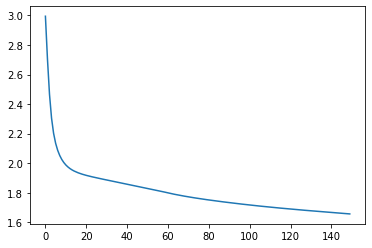

In [573]:
plt.plot(losses)

In [574]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test, A1test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 49 %


In [575]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
a1 = torch.tensor(resampled['A_t1'].values).to(torch.long)-1
# sampled_t0.head()
probs = policy(torch.column_stack((sample, a0, a1)))
m = Categorical(logits=probs)
resampled['A_t2'] = (m.sample()+1).numpy()

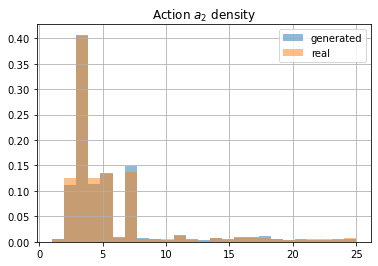

In [576]:
resampled['A_t2'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t2['A_t2'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_2$ density')
plt.show()

# Predicting actions $a_3$ using $x_0,a_0,x_1, a_1, x_2, a_2, x_3$

In [577]:
icuuniqueids = MIMIC_combined_raw.loc[MIMIC_combined_raw['gender']==gender, 'icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]

X = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(trainidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)
Xtestmimic = torch.FloatTensor(MIMIC_combined_raw[(MIMIC_combined_raw['gender']==gender) & (MIMIC_combined_raw['icustay_id'].isin(testidx))].drop(columns=['icustay_id', 'gender', 'A_t0', 'A_t1', 'A_t2', 'A_t3', 'A_t4']).values)

A0 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t0'].values-1).to(torch.long)
A0test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t0'].values-1).to(torch.long)

A1 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t1'].values-1).to(torch.long)
A1test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t1'].values-1).to(torch.long)

A2 = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t2'].values-1).to(torch.long)
A2test = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t2'].values-1).to(torch.long)

Y = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(trainidx), 'A_t3'].values-1).to(torch.long)
Ytest = torch.tensor(MIMIC_combined_raw.loc[(MIMIC_combined_raw['gender']==gender) & MIMIC_combined_raw['icustay_id'].isin(testidx), 'A_t3'].values-1).to(torch.long)

train = data_utils.TensorDataset(torch.column_stack((X, A0, A1, A2)), Y)
trainloader = torch.utils.data.DataLoader(train, batch_size=32)
test = data_utils.TensorDataset(torch.column_stack((Xtestmimic, A0test, A1test, A2test)), Ytest)
testloader = torch.utils.data.DataLoader(test, batch_size=32)

loss_func = torch.nn.CrossEntropyLoss()
policy = PolicyNetwork(input_dim=X.shape[1] + 3, output_dim=25)
optimizer = torch.optim.SGD(policy.parameters(), lr=0.001)
losses = []

In [590]:
for epoch in tqdm(range(500)):
    for data, label in trainloader:
        prediction = policy(data)     # input x and predict based on x
        loss = loss_func(prediction, label)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_loss = 0
            for test_data, test_label in testloader:
                test_loss += loss_func(policy(test_data), test_label)
            losses.append(test_loss.item()/len(testloader))

100%|██████████| 500/500 [00:12<00:00, 39.60it/s]


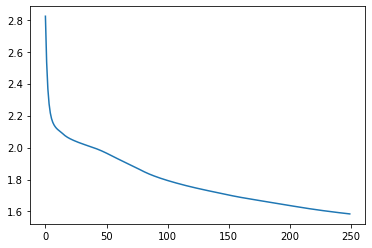

In [591]:
plt.plot(losses)

In [593]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    outputs = policy(torch.column_stack((Xtestmimic, A0test, A1test, A2test)))
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
#     predicted = Categorical(softmax(outputs)).sample()
    total += Xtestmimic.size(0)
    correct += (predicted == Ytest).sum().item()

print('Accuracy of the policy network: %d %%' % (
    100 * correct / total))

Accuracy of the policy network: 60 %


In [594]:
a0 = torch.tensor(resampled['A_t0'].values).to(torch.long)-1
a1 = torch.tensor(resampled['A_t1'].values).to(torch.long)-1
a2 = torch.tensor(resampled['A_t2'].values).to(torch.long)-1
# sampled_t0.head()
probs = policy(torch.column_stack((sample, a0, a1, a2)))
m = Categorical(logits=probs)
resampled['A_t3'] = (m.sample()+1).numpy()

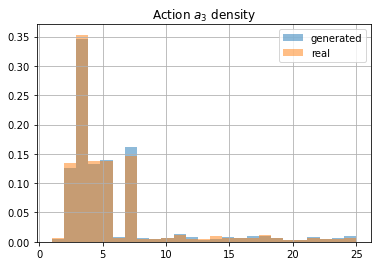

In [595]:
resampled['A_t3'].hist(bins=25, density=True, alpha=0.5)
MIMIC_t3['A_t3'].hist(bins=25, density=True, alpha=0.5)
plt.legend(['generated', 'real'])
plt.title('Action $a_3$ density')
plt.show()

In [596]:
resampled.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4,A_t0,A_t1,A_t2,A_t3
0,23832.193245,55.210393,40.089567,194.416230,1709.216439,7.445745,77.044905,3406.926785,59.574287,2842.634864,...,154.152533,20.607331,36.583942,3097.997106,109.671245,76.907547,2,4,3,3
1,22873.621026,68.531044,48.822940,91.285906,1323.476895,7.499004,91.686139,3301.135201,59.342156,1065.330446,...,170.277438,20.944791,37.317977,3171.210569,133.219191,95.061127,7,7,5,7
2,24049.314899,15.246774,37.622156,244.326904,1517.344023,7.316952,84.697336,3712.552399,58.902043,1427.211700,...,158.139176,15.511110,36.824115,3210.560151,117.980263,72.009069,3,3,3,7
3,24087.029713,90.833317,58.199225,89.952651,1968.729838,7.367603,84.460801,3632.521086,56.746091,1659.120450,...,154.998290,22.314930,37.548684,3220.919711,137.477721,88.661675,4,7,7,7
4,19995.925588,90.400111,49.247557,173.498291,1004.404524,7.091200,79.861743,3726.604893,57.860118,3018.898380,...,214.304811,24.229284,36.848720,3234.004985,125.594835,116.277215,3,3,3,3


# Visualising trajectories

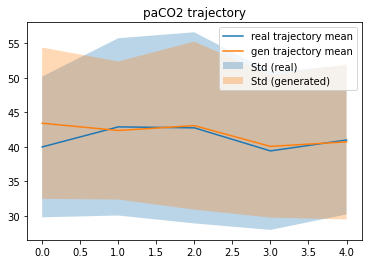

In [600]:
col_name = "paCO2"
At = [2,2,2,2]

col_v = []
col_v_ub = []
col_v_lb = []
col_v_real = []
col_v_ub_real = []
col_v_lb_real = []

resampled_filtered = resampled.copy()
MIMIC_combined_filtered = MIMIC_combined[MIMIC_combined['gender']==gender].copy()

for t in range(len(At)):
    resampled_filtered = resampled_filtered[resampled_filtered[f'A_t{t}']==At[t]]
    MIMIC_combined_filtered = MIMIC_combined_filtered[MIMIC_combined_filtered[f'A_t{t}']==At[t]]

for t in range(5):
    col_v_lb_real.append(resampled_filtered[f'{col_name}_t{t}'].mean() - resampled_filtered[f'{col_name}_t{t}'].std())
    col_v_ub_real.append(resampled_filtered[f'{col_name}_t{t}'].mean() + resampled_filtered[f'{col_name}_t{t}'].std())
    col_v_real.append(resampled_filtered[f'{col_name}_t{t}'].mean())
    col_v_lb.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean() - MIMIC_combined_filtered[f'{col_name}_t{t}'].std())
    col_v_ub.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean() + MIMIC_combined_filtered[f'{col_name}_t{t}'].std())
    col_v.append(MIMIC_combined_filtered[f'{col_name}_t{t}'].mean())
    
plt.plot(col_v_real, label='real trajectory mean')
plt.plot(col_v, label='gen trajectory mean')
plt.fill_between(list(range(5)), col_v_lb_real, col_v_ub_real, alpha=0.3, label='Std (real)')
plt.fill_between(list(range(5)), col_v_lb, col_v_ub, alpha=0.3, label='Std (generated)')
plt.title(f'{col_name} trajectory')
plt.legend()
plt.show()

In [388]:
resampled.head()

,age,Weight_kg,paCO2_t0,paO2_t0,HCO3_t0,Arterial_pH_t0,Calcium_t0,Chloride_t0,DiaBP_t0,Glucose_t0,...,Potassium_t4,RR_t4,Temp_C_t4,Sodium_t4,SysBP_t4,HR_t4,A_t0,A_t1,A_t2,A_t3
0,24770.335773,64.997229,40.268174,174.818411,1740.289396,7.376803,86.387445,3604.830083,56.667456,1045.036094,...,171.459158,20.030122,36.510641,3146.782039,127.503700,68.107519,3,3,4,3
1,27512.828387,72.361558,61.778323,240.651930,2299.101035,7.464648,87.257213,3380.959818,39.121156,1532.478935,...,137.151102,18.905314,36.723725,3249.206034,147.492847,83.624424,7,7,5,5
2,28084.437483,39.351306,38.642559,492.450936,982.189259,7.338260,90.779150,3147.820228,69.217022,1562.327900,...,156.651230,26.509852,37.543689,3173.814334,125.149557,105.158064,3,3,3,3
3,27039.917660,72.742704,32.316557,271.194090,132.409183,7.305834,77.142680,2983.590424,72.683234,1026.044623,...,160.618393,18.725464,36.143981,3034.631792,126.407034,82.033697,3,2,3,7
4,26038.891433,75.563477,56.987297,85.865652,1210.271148,7.321880,81.025351,3606.659093,57.475590,1188.935186,...,183.389937,22.269611,37.052676,3204.705290,130.899840,75.050679,3,3,5,5
